In [148]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['patch.force_edgecolor'] = True
plt.rcParams['figure.figsize'] = (16.0, 8.0)
import data_loader
import warnings
warnings.filterwarnings('ignore')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

# Prepare Data

### Preprocessing / Pipeline Creation

In [2]:
# load data (provided method)
train_data, valid_data = data_loader.load_train_data('Data/adult.data', valid_rate=0.1, is_df=True)
test_data = data_loader.load_test_data('Data/adult.test', is_df=True)

In [3]:
# drop unnecessary features (fnlwgt, education)
train_data = train_data.drop(columns = ['fnlwgt', 'education'])
valid_data = valid_data.drop(columns = ['fnlwgt', 'education'])
test_data = test_data.drop(columns = ['fnlwgt', 'education'])

In [4]:
# numerical processing pipeline
num_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
num_transformer = Pipeline(steps = [('scaler', StandardScaler())]) # currently just the scaler (can add more later)

In [5]:
# categorical processing pipeline
cat_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 
                'native-country']
cat_transformer = Pipeline(steps = [('imputer', SimpleImputer(missing_values = ' ?',strategy = 'most_frequent')),
                                    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

In [6]:
# create preprocessor containing above pipelines
preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_features), 
                                               ('cat', cat_transformer, cat_features)])

In [80]:
# create various pipelines, each invoking the preprocessor and a different classifier

# Logistic Regression
LogR_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', LogisticRegression())])
# Linear SVM
SVM_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LinearSVC(dual = False))]) 
# Gaussian Naive Bayes
GNB_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('transformer',FunctionTransformer(lambda x: x.todense(), accept_sparse=True)), #make dense
                           ('classifier', GaussianNB(priors = None))])

# K-Nearest Neighbors
KNN_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('transformer',FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
                           ('classifier', KNeighborsClassifier())])

In [8]:
# convert target values to binary categories
train_data = train_data.replace(to_replace = ' >50K', value = 1)
train_data = train_data.replace(to_replace = ' <=50K', value = 0)
valid_data = valid_data.replace(to_replace = ' >50K', value = 1)
valid_data = valid_data.replace(to_replace = ' <=50K', value = 0)
test_data = test_data.replace(to_replace = ' >50K', value = 1)
test_data = test_data.replace(to_replace = ' <=50K', value = 0)

In [9]:
# verify correct shape
train_data.shape

(29315, 13)

In [10]:
# remove target values
X = train_data.drop(columns = 'income')
Y = train_data['income']

In [11]:
# split into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2)

# Model Selection / Hyperparameter Tuning

### Logistic Regression

In [27]:
# use parameter grid to pass a range of hyperparameters to the pipeline - automatically saves best result
# can add other hyperparemeters/preprocessing options here
LogR_param_grid = {
    'classifier__C': [0.1, 1.0, 10, 100], # error term penalty
    'classifier__solver': ['lbfgs', 'saga', 'liblinear', 'newton-cg'] # logistic regression algorithm
}

In [28]:
# create grid search and fit to data
LogR_GS = GridSearchCV(LogR_pipe, LogR_param_grid, cv=3)
LogR_GS.fit(X_train, Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['age', 'education-num', 'capital...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__C': [0.1, 1.0, 10, 100], 'classifier__solver': ['lbfgs', 'saga', 'liblinear', 'newton-cg']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [112]:
# print highest score and best parameters
print(LogR_GS.best_score_)
print(LogR_GS.best_params_)

0.8492239467849224
{'classifier__C': 0.1, 'classifier__solver': 'lbfgs'}


Text(0.5,1,'Logistic Regression - Grid Search Scores')

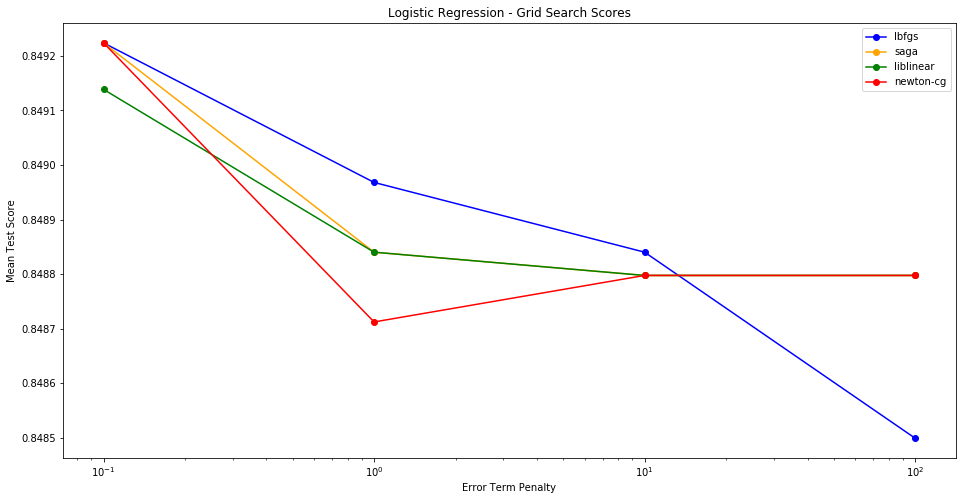

In [78]:
# plot
X_axis = np.array(LogR_GS.cv_results_['param_classifier__C'].data, dtype=float)
plt.semilogx(X_axis[::4], LogR_GS.cv_results_['mean_test_score'][::4], color = 'blue', marker = 'o', label = 'lbfgs')
plt.semilogx(X_axis[1::4], LogR_GS.cv_results_['mean_test_score'][1::4], color = 'orange', marker = 'o', label = 'saga')
plt.semilogx(X_axis[2::4], LogR_GS.cv_results_['mean_test_score'][2::4], color = 'green', marker = 'o', label = 'liblinear')
plt.semilogx(X_axis[3::4], LogR_GS.cv_results_['mean_test_score'][3::4], color = 'red', marker = 'o', label = 'newton-cg')
plt.xlabel("Error Term Penalty")
plt.ylabel("Mean Test Score")
plt.legend(loc = 'best')
plt.title("Logistic Regression - Grid Search Scores")

### Linear SVM

In [13]:
SVM_param_grid = {
    'classifier__C': [0.1, 1.0, 10, 100], # penalty of the error term
    'classifier__penalty': ['l1', 'l2'] #regularization penalty type
}

In [14]:
SVM_GS = GridSearchCV(SVM_pipe, SVM_param_grid, cv=3)
SVM_GS.fit(X_train, Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['age', 'education-num', 'capital...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__C': [0.1, 1.0, 10, 100], 'classifier__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [113]:
print(SVM_GS.best_score_)
print(SVM_GS.best_params_)

0.8488401842060379
{'classifier__C': 0.1, 'classifier__penalty': 'l1'}


### Gaussian Naive Bayes

In [37]:
GNB_param_grid = {
    'classifier__var_smoothing': [1e-9, 0.1, 1.0, 10, 100]
}

In [33]:
GNB_GS = GridSearchCV(GNB_pipe, GNB_param_grid, cv=3)
GNB_GS.fit(X_train, Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['age', 'education-num', 'capital...eprecated',
          validate=None)), ('classifier', GaussianNB(priors=None, var_smoothing=1e-09))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__var_smoothing': [1e-09, 0.1, 1.0, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [34]:
print(np.amax(GNB_GS.cv_results_['mean_test_score']))
print(GNB_GS.best_params_)

0.7952839843083745
{'classifier__var_smoothing': 1.0}


Text(0.5,1,'Gaussian Naive Bayes w/ Variable Smoothing')

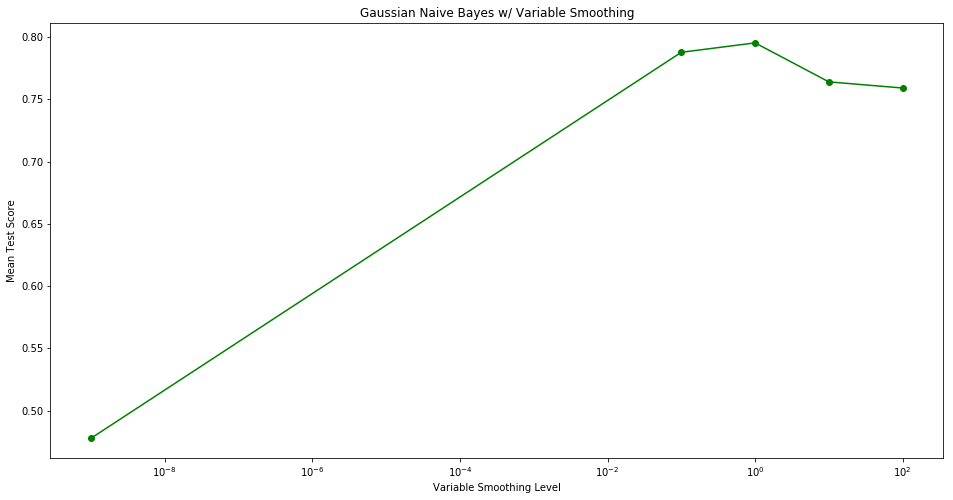

In [35]:
# plot
plt.semilogx(GNB_param_grid['classifier__var_smoothing'], GNB_GS.cv_results_['mean_test_score'], 'g', marker = 'o')
plt.xlabel("Variable Smoothing Level")
plt.ylabel("Mean Test Score")
plt.title("Gaussian Naive Bayes w/ Variable Smoothing")

### K-Nearest Neighbors

In [85]:
KNN_param_grid = {
    'classifier__n_neighbors': [10, 25, 50, 75, 100],
    'classifier__weights': ['uniform','distance']
}

In [86]:
KNN_GS = GridSearchCV(KNN_pipe, KNN_param_grid, cv=3)
KNN_GS.fit(X_train, Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['age', 'education-num', 'capital...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__n_neighbors': [10, 25, 50, 75, 100], 'classifier__weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [87]:
print(np.amax(KNN_GS.cv_results_['mean_test_score']))
print(KNN_GS.best_params_)

0.8461538461538461
{'classifier__n_neighbors': 25, 'classifier__weights': 'uniform'}


Text(0.5,1,'KNN')

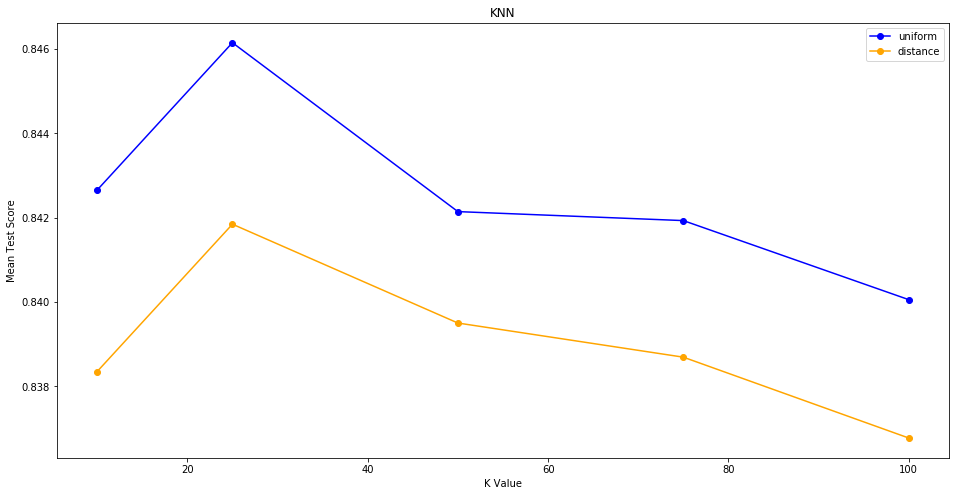

In [88]:
# plot
X_axis = np.array(KNN_GS.cv_results_['param_classifier__n_neighbors'].data, dtype=float)
plt.plot(X_axis[::2], KNN_GS.cv_results_['mean_test_score'][::2], color = 'blue', marker = 'o', label = 'uniform')
plt.plot(X_axis[1::2], KNN_GS.cv_results_['mean_test_score'][1::2], color = 'orange', marker = 'o', label = 'distance')
plt.xlabel("K Value")
plt.ylabel("Mean Test Score")
plt.legend(loc = 'best')
plt.title("KNN")

### Results

Logistic Regression provides the best score on test data by a very slight margin (~.001) over the other classifiers. Linear SVM and KNN classifiers provided comparable performance, and Gaussian Naive Bayes underperformed in comparison to the rest.

# Ensemble Methods

### Voting + Bagging (with top 3 classifiers from above)

In [162]:
# create bagging classifiers (with hyperparameters chosen above)
samples = 1.0 # sample % of data points in the bagging classifier (bootstrap)
features = 1.0 # sample % of the features (bootstrap)
np.random.seed = 0

LogR_pipe_bag = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', BaggingClassifier(LogisticRegression(C = 0.1, solver = 'lbfgs'),
                                                            max_samples = samples,
                                                            max_features = features,
                                                            bootstrap_features = True))])

SVM_pipe_bag = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', BaggingClassifier(LinearSVC(C = .1, penalty = 'l1', dual = False),
                                                            max_samples = samples,
                                                            max_features = features,
                                                            bootstrap_features = True))]) 

KNN_pipe_bag = Pipeline(steps=[('preprocessor', preprocessor),
                           ('transformer',FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
                           ('classifier', BaggingClassifier(KNeighborsClassifier(n_neighbors = 25, weights = 'uniform'),
                                                            max_samples = samples,
                                                            max_features = features,
                                                            bootstrap_features = True))])

In [163]:
# hard voting with cross-validation, K = 10
kfold = StratifiedKFold(n_splits = 10)
estimators = [('LogR', LogR_pipe_bag),('SVM', SVM_pipe_bag),('KNN', KNN_pipe_bag)]
ensemble = VotingClassifier(estimators, voting = 'hard')
results = cross_val_score(ensemble, X_train, Y_train, cv = kfold)

In [164]:
print(results.mean())

0.8490535937998243


### Random Forests